## Sources
- [GitHub CNN Architecture](https://github.com/mr7495/OCT-classification)

- [Detection and Classification Methods](https://link.springer.com/article/10.1007/s10462-024-10883-3#Sec2)

- [OCT-based deep-learning models for the identification of retinal key signs](https://www.nature.com/articles/s41598-023-41362-4)

- [Evaluating deep learning models for classifying OCT images with limited data and noisy labels](https://www.nature.com/articles/s41598-024-81127-1)

- [Optical Coherence Tomography Image Classification Using Hybrid Deep Learning and Ant Colony Optimization](https://pmc.ncbi.nlm.nih.gov/articles/PMC10422382/)

- [Pytorch Docs](https://pytorch.org/tutorials/beginner/ptcheat.html)

- [Pytorch Course](https://www.youtube.com/watch?v=V_xro1bcAuA&t=19230s)

- [Pytorch Book](https://www.learnpytorch.io/02_pytorch_classification/)

- [Pytorch Course Materials](https://github.com/mrdbourke/pytorch-deep-learning)

- [Hugging Face](https://huggingface.co/models?library=timm,pytorch&sort=trending)

- [Kaggle](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data/comments)

- [Pytorch CNN Model GitHub](https://github.com/shre-db/OCT-Retinal-Disease-Detection-CNN)

- [Article On CNN Models](https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48)

- [ML TIPS](https://www.youtube.com/watch?v=oMc9StPVzOU)

- [Machine Learning in Clinical Interpretation ]( https://www.mdpi.com/2306-5354/10/4/407)
- [detecting and classifying age](https://link.springer.com/article/10.1007/s10462-024-10883-3#Sec2)
- [GAN network Article](https://link.springer.com/article/10.1007/s00521-021-05826-w)
- [Evaluation Metrics](https://wandb.ai/claire-boetticher/mendeleev/reports/Data-Visualization-for-Image-Classification--VmlldzozMjU5NDUz)


# CNN-03

abstract
more results

**Problem Statement:**
- Create a CNN model from scratch using pytorch and develop a Multi-Class classification solution for Normal, Drusen and CNV OCT images to detect and prevent early stages of rentinal AMD.

**Goal:**
- Compare and contrast the results of this model to the pre-trained model. Minimizing the number of variables between the two models. Define and evaluate more metrics for CNN02 and compare similar metrics with CNN03.

**Expected Results:**
- CNN02 is leveraging the use of efficientNetv2_b0 pre-trained on much more data to classify OCT images, while CNN03 is much more limited on resources. This will likely result in a much higher performance from CNN02 than CNN03, in both accuracy and false negatives.


# Imports

In [ ]:

import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv
from glob import glob
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split

In [ ]:
#Loading the data from the UCSD Large Dataset.
!kaggle datasets download -d mmazizi/ucsd-3-class-labeled-retinal-oct-images
!unzip ucsd-3-class-labeled-retinal-oct-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-3.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-4.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-5.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-6.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-7.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-8.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-9.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-1.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-10.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-2.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-3.jpeg  
  inflating: OCTUCSD-3cl

# Data Preparation

In [ ]:
#Data Visualization
train_dir = "/content/OCTUCSD-3class/OCTUCSD-3class/OCT/train"
test_dir = "/content/OCTUCSD-3class/OCTUCSD-3class/OCT/test"
csv_path = "/content/ucsd_train.csv"

In [ ]:
class OCTDataset(Dataset):
    def __init__(self, folder_paths, sample_size, image_size=(224, 224), transform=None):
        self.image_paths = []

        # Sample images from each class
        for path in folder_paths:
            images = glob(os.path.join(path, "*.jpeg"))
            sampled_images = random.sample(images, sample_size)
            self.image_paths.extend(sampled_images)

        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Read, resize, and pre-process image
        # Load and resize image with OpenCV
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB


        img = cv.resize(img, self.image_size)

        # Convert image to tensor
        img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0  # Normalize to [0,1]

        if self.transform:
            img = self.transform(img)  # Apply additional transforms
        label = self.get_label_from_path(img_path)

        return img, label

    def get_label_from_path(self, path):
        if "NORMAL" in path:
            return 2
        elif "CNV" in path:
            return 1
        elif "DRUSEN" in path:
            return 0

# Define the dataset paths and initialize the Dataset and DataLoader
train_path = "/content/OCTUCSD-3class/OCTUCSD-3class/OCT/train"
folder_paths = [
    os.path.join(train_path, "NORMAL"),
    os.path.join(train_path, "CNV"),
    os.path.join(train_path, "DRUSEN")
]


sample_size = 6000  # Specify the number of images to sample from each class
# Create the dataset and data loader
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),  # 25% chance of flipping horizontally
    transforms.RandomVerticalFlip(p=0.25),    # 25% chance of flipping vertically
    transforms.RandomRotation(degrees=10),
    transforms.Grayscale(num_output_channels=3),  # Make grayscale images 3-channel
    transforms.Resize((224, 224)),                # Resize to 224x224
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


full_dataset = OCTDataset(folder_paths, sample_size)

train_size = int(0.8 * len(full_dataset)) #80% of the data
val_size = len(full_dataset) - train_size #20% of the data

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

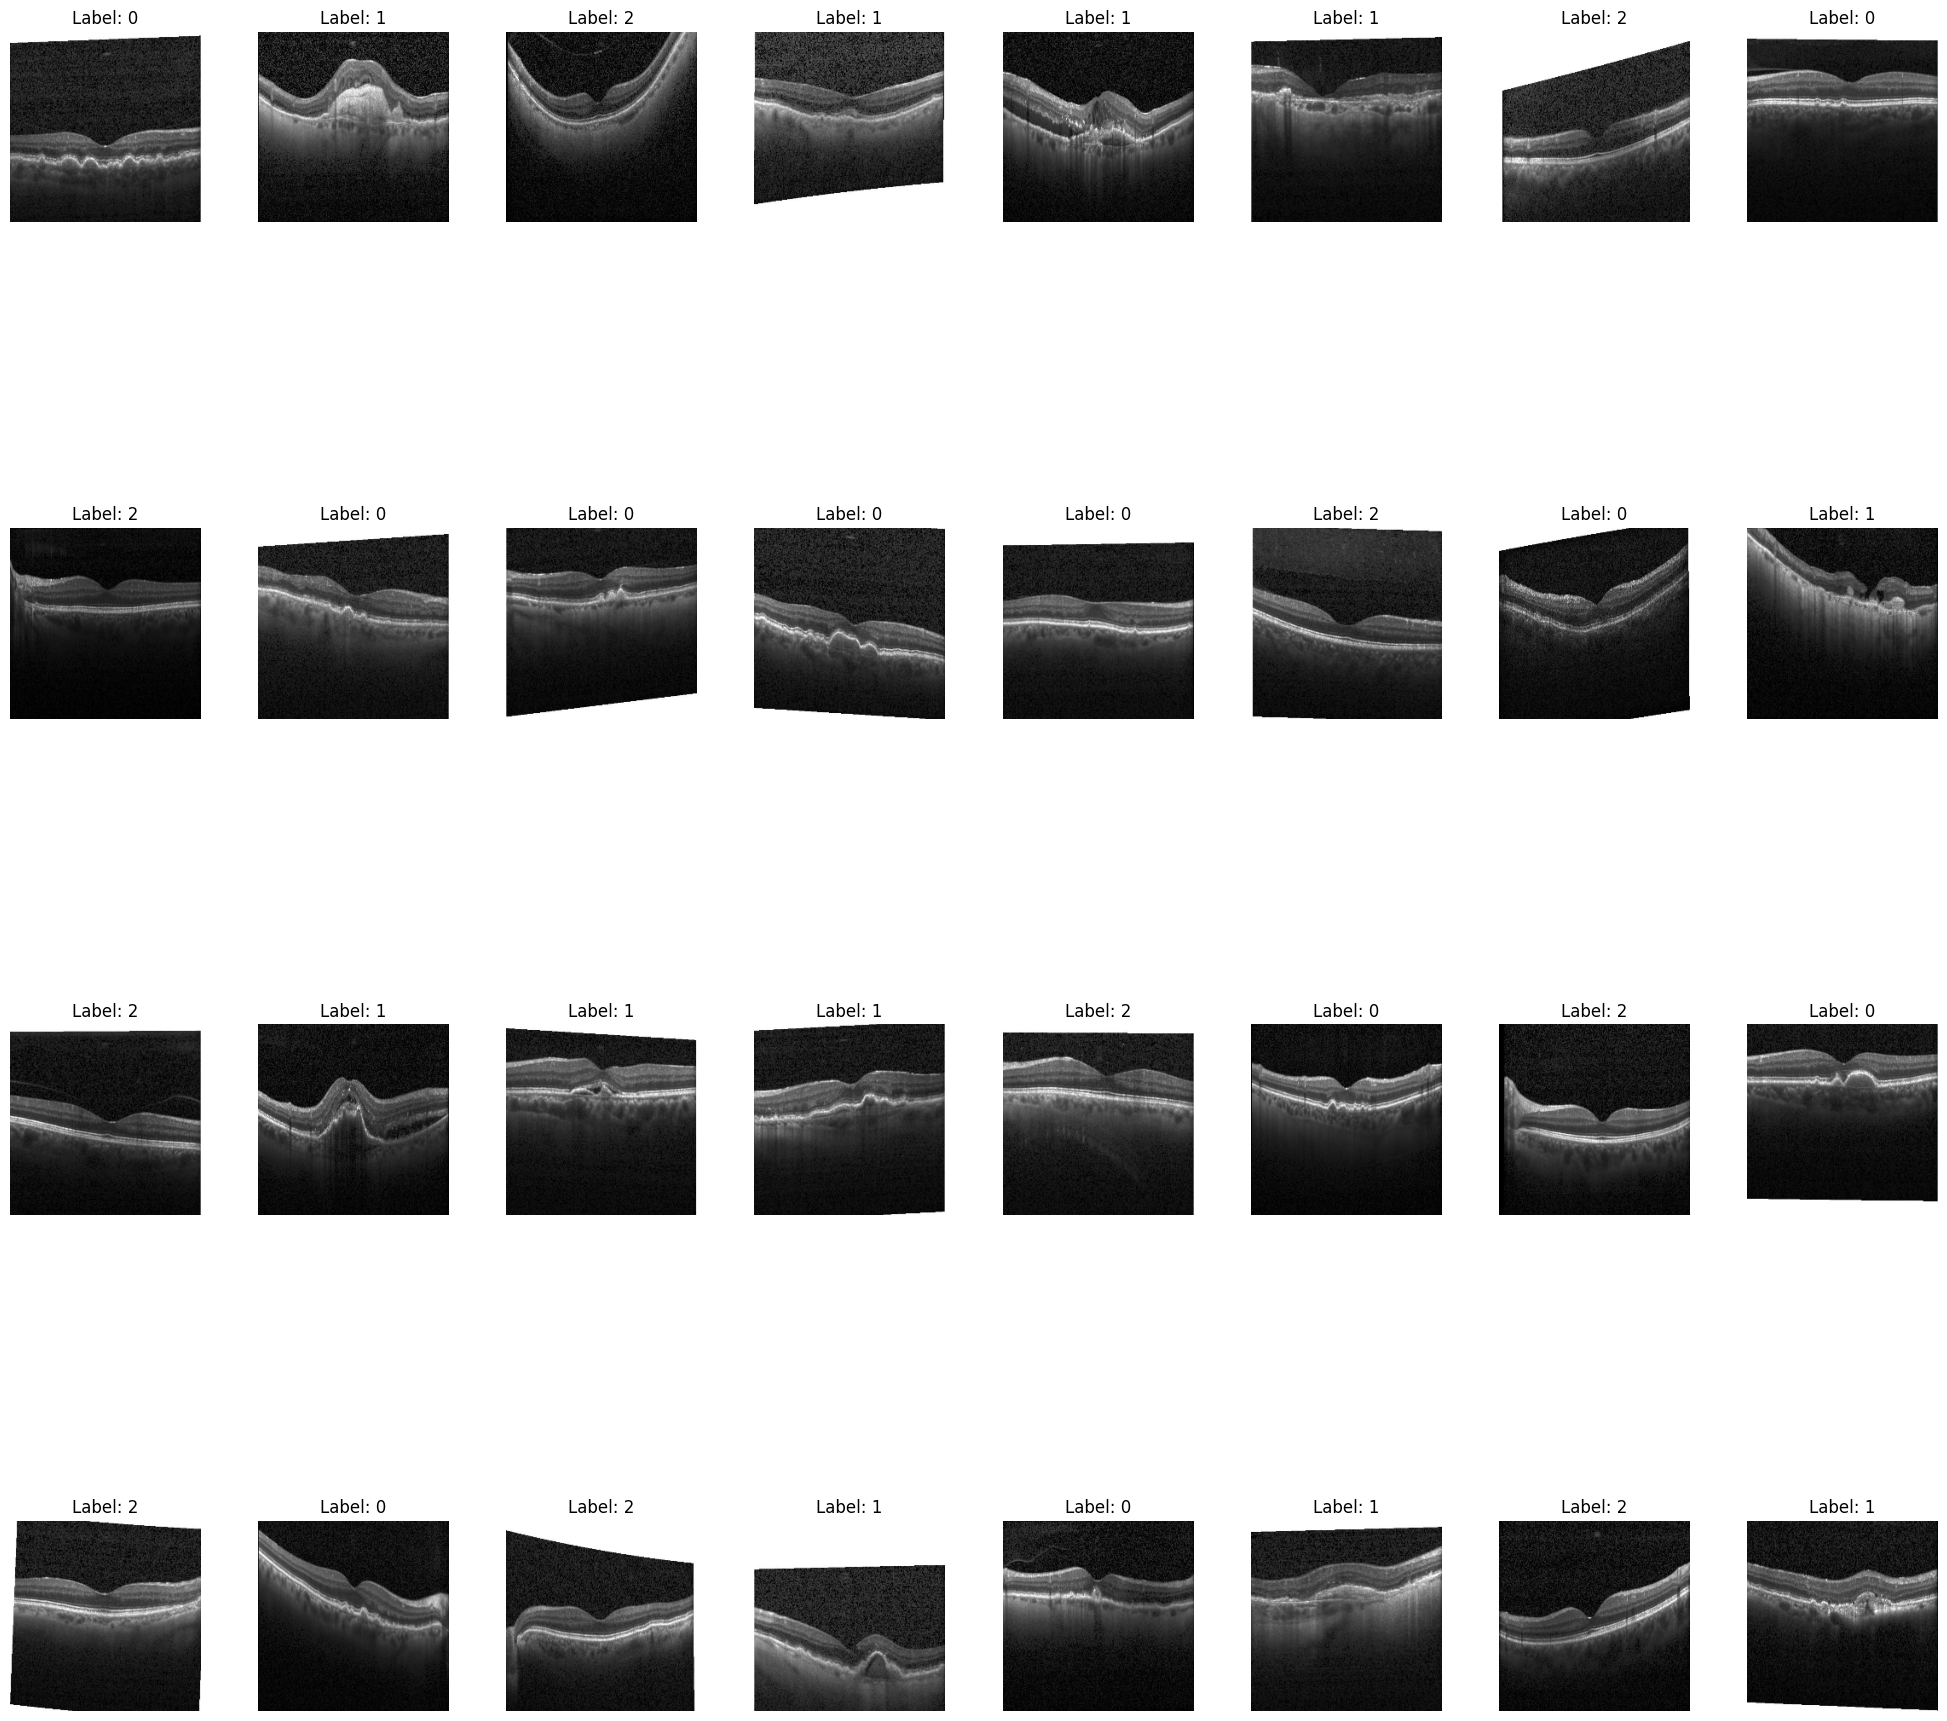

In [ ]:

img_list = []
label_list = []
for i in range(32):
  train_features, train_labels = next(iter(train_loader))
  image = train_features[0].squeeze().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
  labels = train_labels[0]
  img_list.append(image)
  label_list.append(labels)


fig, ax = plt.subplots(4,8, figsize=(20,20))
fig.tight_layout()
ind = 0
for ax,img in zip(ax.flat, img_list):
    ax.axis('off')
    ax.imshow(img) #show each image
    ax.set_title(f"Label: {label_list[ind]}")
    ind+=1
plt.show()

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


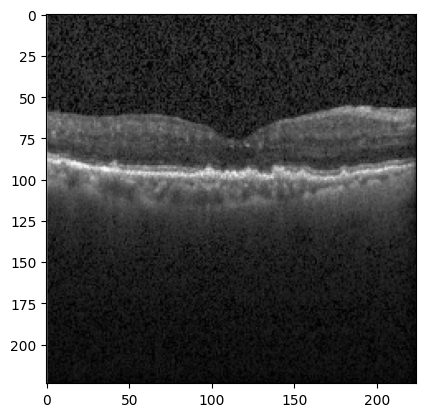

Label: 0
Tyoe: <class 'numpy.ndarray'>


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Visualize one of the images in the batch
img = train_features[0].squeeze().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
plt.imshow(img, cmap="gray")


plt.show()
print(f"Label: {train_labels[0]}")
print(f"Tyoe: {type(img)}")

In [ ]:
#LABELS: 0:DRUSEN, 1:CNV, 2:NORMAL
df = pd.read_csv(csv_path)
# Display the first 5 rows of the dataset
print(df.head())

   Unnamed: 0.1  Unnamed: 0                                file-name  class-id
0         16794       16794        OCT/train/CNV/CNV-1781140-39.jpeg         1
1         60242       60242  OCT/train/NORMAL/NORMAL-4446447-11.jpeg         2
2         74083       74083   OCT/train/NORMAL/NORMAL-4489896-8.jpeg         2
3         62436       62436  OCT/train/NORMAL/NORMAL-1193128-13.jpeg         2
4         88057       88057  OCT/train/NORMAL/NORMAL-7398942-30.jpeg         2


In [ ]:
# #Dataset Preparation
# class CustomDataset(Dataset):
#   def __init__(self, csv_file, root_dir, size, transforms=None):
#       pass

# Model Architecture

**Key CNN Layers**
- Conv layers: Primary layer that applies filters that slide across the image to extract specific features
- Activation Function: Indroduces Non-linearity
- Pooling Layer: Downsamples the feature maps from the previous conv layer while preserving important features and reducing spacial dimesions (max pooling and avg pooling)
- Fully Connected: Every neuron is connected between previous layer used to integrate high level features for final classification
- Output Layer: produces the final prediction usally a probability distribution for different classes.


> CNNs gather features starting from low level features building up to more complex features

---

**Initial Model**
Simple CNN structure with 2 convolutional layers and 2 fully connected layers.

  - Input Layer: First Convolutional Layer, 1 input channel for a grayscale image, padding the input with 0s to ensure the spacial dimensions of input/output match (Channels,Height,Width).
    - (1, 224, 224) -> (32, 224,224)

  - Pooling Layer: Reduce the spacial dimensions of the feature maps while retaining important features,
    - (32,224,224) -> (32,112,112)

  - Second Convolutional Layer: Extracts higher level features from the feature maps.
    - (32,112,112) -> (64, 112,112)
  
  ...

    - (64, 112, 112) -> (64, 56, 56)

  - Full Connected Layer: Flattens the feature maps, Learns from high dimensional feature space to a lower dimensional feature space. inputs the feature maps and outputs a single dimensional tensor.
    - (64, 56, 56) -> (128)

  - Output Layer: The second fully connected layer, produces the final output based on the number of classes, in this case we have 3 outputs for the 3 classes.
    - (128) -> (NUM_CLASSES)

    


**Forward Function**

Activation Functions
- ReLU:
  - Applied after each convolutional and fully connected layer except the output.
  - Indroduced non-linearity, allowing for more complex patterns
- Softmax:
  - During inference apply softmax to convert logits into probabilities
  >Logits refer to the raw, unnormalized scores output by a model's final layer, typically before applying any activation function like Softmax. These logits represent the model's confidence about each class in classification problems

Foward Pass:
   - Pass in our image batch (input data), (batch_size, channels, height, width)
   - step1: conv1 -> ReLU -> Pool
   - step2: conv2 -> ReLU -> Pool
   - step3: Flatten Tensor, now a 2D tensor. (batch_size, Spacial Dimensions)
   - step4: fully connected -> ReLU
   - step5: fully connected output.


Changes:
1. Batch Normalization, speeds up training by normalizing the activations, stabalizes learning by reducing internal covariate shift
2. Added additional convolutional layers to extract deeper features

3. Added additional pooling layers, reduces dimensionality making computation faster
4. Adaptive pooling for dynamic input size, adaptive pooling allows the final map is always (4,4)
5. additional fully connected layers, learns more complex relationships
6. Dropout layers to prevent overfitting by randomly dropping some neurons during training.

What's next:
- Data augmentation
- Compare to VGG




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F

class OCT_Classification_Model(nn.Module):
  def __init__(self, input_channels=3, num_classes=3):
    super(OCT_Classification_Model, self).__init__()

    self.feature_maps = {}  # Dictionary to store feature maps

    # Convolutional block 1
    self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    # Convolutional block 2
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(256)

    # Pooling layers
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

    # Fully connected layers
    self.fc1 = nn.Linear(256 * 4 * 4, 512)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, 128)
    self.dropout2 = nn.Dropout(0.3)
    self.fc3 = nn.Linear(128, num_classes)

    # Register hooks
    self.register_hooks()

  def forward(self, x):
      # First conv block
      x = self.pool(F.relu(self.bn1(self.conv1(x))))
      x = self.pool(F.relu(self.bn2(self.conv2(x))))

      # Second conv block
      x = self.pool(F.relu(self.bn3(self.conv3(x))))
      x = self.pool(F.relu(self.bn4(self.conv4(x))))

      # Adaptive pooling
      x = self.adaptive_pool(x)

      # Flatten
      x = x.view(x.size(0), -1)

      # Fully connected layers
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = F.relu(self.fc2(x))
      x = self.dropout2(x)
      x = self.fc3(x)  # No Softmax (CrossEntropyLoss handles it)

      return x

  def register_hooks(self):
      """Register hooks to capture feature maps from selected layers."""
      def hook_fn(module, input, output):
          layer_name = module.__class__.__name__
          self.feature_maps[layer_name] = output.detach()  # Save feature map

      # Attach hooks to specific layers
      self.conv1.register_forward_hook(hook_fn)
      self.conv2.register_forward_hook(hook_fn)
      self.conv3.register_forward_hook(hook_fn)
      self.conv4.register_forward_hook(hook_fn)



In [ ]:

model_test = OCT_Classification_Model()
#list(model_test.parameters())
#model_test.state_dict()

# Training Pipeline
- training loop, 1 epoch is a single forward pass through the data.
- **Hyperparameters**
  - Epochs: 5
  - Batch Size: 16 (Limited on memory)
  - Optimizer: Adam
  - Loss Function(Criterion): Cross Entropy
  - Learning Rate: .001

In [ ]:
from tqdm import tqdm
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cuda"):
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        correct_val_predictions = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val_predictions += torch.sum(preds == labels)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct_val_predictions.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")

    print("Training complete")
    return model

In [ ]:
# Training
def training_loop(model, epochs, train_loader, test_loader, loss_func, optimizer):
  for epoch in range(epochs):
    #get data, image and label
    data = next(iter(train_loader))
    image = data['image']
    label = data['label']

    #set model to train mode, tracking gradients
    model.train()

    #forwad pass the data through the model
    output = model(image)

    #Calculate loss
    loss = loss_func()

    #zero the optimizer
    optimizer.zero_grad()

    #Back propagation
    loss.backward()

    #optimizer step
    optimizer.step()

    #validation, stop tracking gradients
    model.eval()




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 0.001
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_test.parameters(), lr=learning_rate)


trained_model = train_model(model_test, train_loader, val_loader, criterion, optimizer, num_epochs=epochs, device=device)

Epoch 1/5
----------


100%|██████████| 450/450 [46:36<00:00,  6.21s/it]

Train Loss: 0.7272 Acc: 0.6571


Validation Loss: 0.5008 Acc: 0.7839
Epoch 2/5
----------


100%|██████████| 450/450 [47:15<00:00,  6.30s/it]

Train Loss: 0.5278 Acc: 0.7819


Validation Loss: 0.4520 Acc: 0.8219
Epoch 3/5
----------


100%|██████████| 450/450 [47:47<00:00,  6.37s/it]

Train Loss: 0.4618 Acc: 0.8177


Validation Loss: 0.5342 Acc: 0.7928
Epoch 4/5
----------


100%|██████████| 450/450 [47:45<00:00,  6.37s/it]

Train Loss: 0.4055 Acc: 0.8438


Validation Loss: 0.4508 Acc: 0.8106
Epoch 5/5
----------


100%|██████████| 450/450 [47:46<00:00,  6.37s/it]

Train Loss: 0.3573 Acc: 0.8666


Validation Loss: 0.4484 Acc: 0.8094
Training complete


In [21]:
#saving weights
from google.colab import drive
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/OCT_model_weights.pth"
trained_weights = trained_model.state_dict()
torch.save(trained_weights, save_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
torch.save(trained_weights, "model_weights.pth")

Things to try:
- Add more layers, convolutional and pooling
- update forward function

  - change optimizer
  - transformations
  - optimizer
  - Shuffle Dataset, randomly organize, feed in randomly.
  - STUDY VGG-16 structure and compare with the model.
  - Follow the structure
  

**Increasing CNN Performance**
- Data Augmentation
  - Increase the diversity of training data by applying transformations

- Additional/different layers

- Hyperparameter tuning
  - Optimize learning rates, optimizers and other hyperparameters

- Early stopping.

- Combining models to improve accuracy.


**GAN Network Potentials**
-  Due to their demonstrated ability to generate high quality and diverse synthetic images, we propose the application of GANs here to augment data for a patch-based approach to OCT chorio-retinal boundary segmentation
- Improves data security



Changes Made:
- Train with Lots of data augementation
  - everything from previous train including
  - OpenCV Morphological closed operation



  - Send frontiers paper
  - research VGG-16 code
  - Try layer by layer buidling, hooks
  - Customize pytorch layers

  


# Evaluation

- **Metrics**
  - Accuracy: How correct our predictions were
  - Confusion Matrix: Visualize True/False Positives (useful for medical diagnosis)
  - Precision
  

In [19]:
#Extract Features
import matplotlib.pyplot as plt

# Load a sample image (assuming img is preprocessed correctly)
img = torch.randn(1, 3, 224, 224)  # Example random tensor for testing

# Forward pass
model = OCT_Classification_Model()
output = model(img)

# Retrieve stored feature maps
for layer, feature_map in model.feature_maps.items():
    print(f"Feature Map from {layer}: {feature_map.shape}")


import matplotlib.pyplot as plt
S
def visualize_feature_maps(feature_map, title="Feature Map"):
    """Displays feature maps from convolutional layers."""
    num_filters = feature_map.shape[1]  # Get number of channels (filters)
    fig, axes = plt.subplots(1, min(num_filters, 6), figsize=(12, 6))  # Show up to 6 filters
    fig.suptitle(title)

    for i in range(min(num_filters, 6)):  # Show first 6 feature maps
        ax = axes[i]
        ax.imshow(feature_map[0, i].cpu().numpy(), cmap="gray")
        ax.axis("off")

    plt.show()

# Example: Visualize feature maps from conv1
visualize_feature_maps(model.feature_maps["Conv2d"], title="Conv1 Feature Maps")


In [ ]:
#Evalaute the model with the testing set